# Transcriptomics visualizations
Now that we've used R to get the differentially expressed genes, we can do some visualizations of what those look like for different comparisons.

In [1]:
from os import listdir
from os.path import splitext, abspath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from collections import defaultdict, Counter
import subprocess
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from get_arabidopsis_descriptions import get_arabidopsis_descriptions
from make_DEG_figure import makeDEGfigure
from upsetplot import from_contents, plot, UpSet
import warnings
import json

## Read in the data

In [2]:
datapath = '../data/deseq2_output/'
time_comparisons = {}
o2_comparisons = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'vs':
        time_comparisons[name] = pd.read_csv(datapath+f)
    elif f.split('_')[1] == 'o2':
        o2_comparisons[name] = pd.read_csv(datapath+f)

In [3]:
time_comparisons.keys(), o2_comparisons.keys()

(dict_keys(['1h_vs_7h_2o2', '1h_vs_7h_40o2', '1h_vs_7h_21o2']),
 dict_keys(['1h_o2_40_21', '7h_o2_2_21', '1h_o2_2_21', '7h_o2_40_21']))

Order the dictionaries by a sensible order for plotting:

In [4]:
time_comparisons = {k: time_comparisons[k] for k in ['1h_vs_7h_21o2', '1h_vs_7h_2o2', '1h_vs_7h_40o2']}
o2_comparisons = {k: o2_comparisons[k] for k in ['1h_o2_2_21', '1h_o2_40_21', '7h_o2_2_21', '7h_o2_40_21']}

Define the semantic names to be used in the plots:

In [5]:
conditions_semantic = {
    '1h_vs_7h_2o2': '7 hours vs. 1 hour at 2% oxygen',
    '1h_vs_7h_40o2': '7 hours vs. 1 hour at 40% oxygen',
    '1h_vs_7h_21o2': '7 hours vs. 1 hour at 21% oxygen',
    '1h_o2_40_21': '40% vs. 21% oxygen at 1 hour',
    '7h_o2_2_21': '2% vs. 21% oxygen at 7 hours',
    '1h_o2_2_21': '2% vs. 21% oxygen at 1 hour',
    '7h_o2_40_21': '40% vs. 21% oxygen at 7 hours'
}
reverse_condition_semantic = {v: k for k, v in conditions_semantic.items()}

## Time comparisons
First, let's take a look at the distributions of the log fold change for the 1 hour vs. 7 hour comparisons.

Text(0.08, 0.5, 'Number of genes')

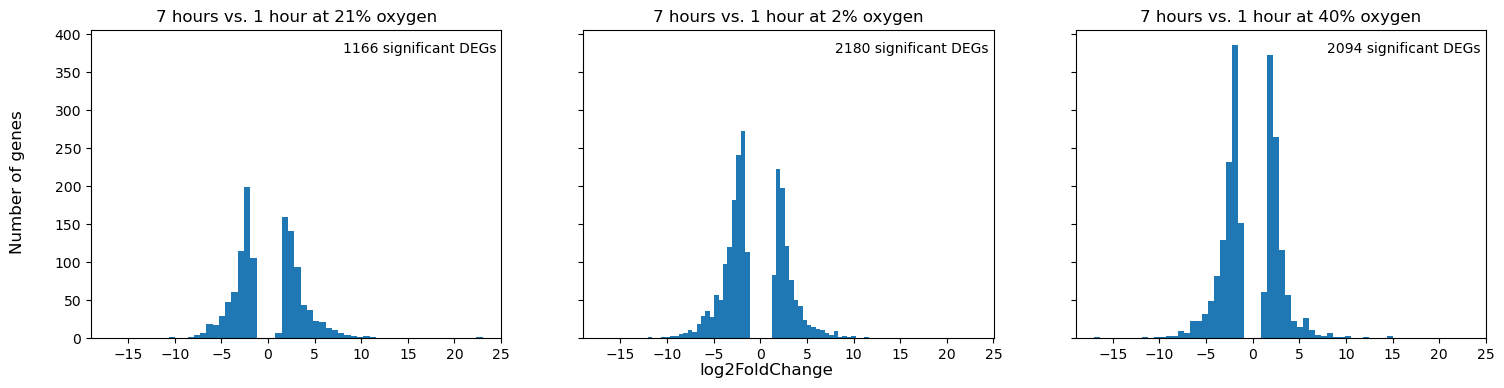

In [6]:
fig, axs = plt.subplots(1, len(time_comparisons), sharex=True, sharey=True, figsize=(len(time_comparisons)*6, 4))

for ax, comp in zip(axs, time_comparisons):
    ax.hist(time_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(conditions_semantic[comp])
    ax.text(8, 375, f'{len(time_comparisons[comp])} significant DEGs')
fig.supxlabel('log2FoldChange')
fig.supylabel('Number of genes', x=0.08)

The presence of so many DEGs after 7 hours at ambient oxygen to me indicates that many of the DEGs we're seeing in the other conditions aren't related to the change in photorespiration as induced by the change in oxygen, but rather normal processed that change over the course of a day. What happens to these distributions if we remove the DEGs from 2% and 40% that are also found with the same directional change in 21%?

In [7]:
two_21_merged = pd.merge(time_comparisons['1h_vs_7h_2o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_21o2'))
two_to_drop = two_21_merged[two_21_merged.log2FoldChange_2o2 * two_21_merged.log2FoldChange_21o2 > 0].gene_id
two_filtered_by_21 = time_comparisons['1h_vs_7h_2o2'][~time_comparisons['1h_vs_7h_2o2'].gene_id.isin(two_to_drop)].reset_index(drop=True)
two_filtered_by_21.shape

(1492, 7)

In [8]:
forty_21_merged = pd.merge(time_comparisons['1h_vs_7h_40o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_40o2', '_21o2'))
forty_to_drop = forty_21_merged[forty_21_merged.log2FoldChange_40o2 * forty_21_merged.log2FoldChange_21o2 > 0].gene_id
forty_filtered_by_21 = time_comparisons['1h_vs_7h_40o2'][~time_comparisons['1h_vs_7h_40o2'].gene_id.isin(forty_to_drop)].reset_index(drop=True)
forty_filtered_by_21.shape

(1280, 7)

Text(0.08, 0.5, 'Number of genes')

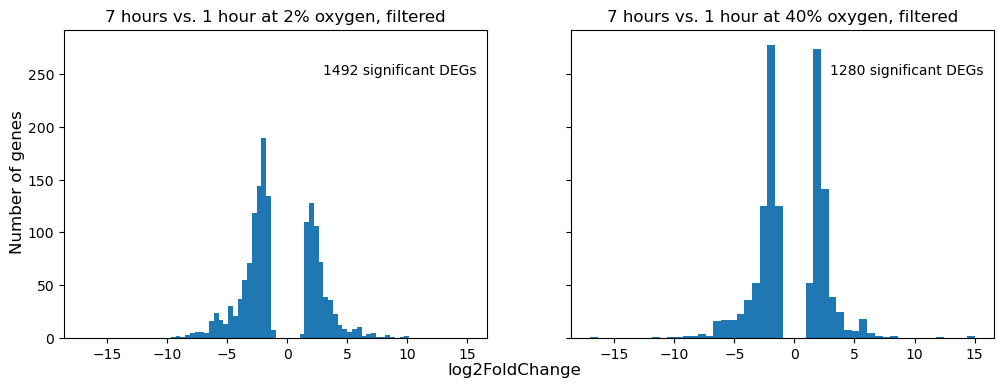

In [9]:
comps_filtered = {
    '7 hours vs. 1 hour at 2% oxygen, filtered': two_filtered_by_21,
    '7 hours vs. 1 hour at 40% oxygen, filtered': forty_filtered_by_21
}
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    ax.hist(comps_filtered[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(3, 250, f'{len(comps_filtered[comp])} significant DEGs')
fig.supxlabel('log2FoldChange')
fig.supylabel('Number of genes', x=0.08)

That substantially reduces the number of genes we're interested in looking at. 

Export the filtered sets:

In [41]:
two_filtered_by_21.to_csv('../data/deseq2_output/2_o2_7h_v_1h_filtered.csv', index=False)
forty_filtered_by_21.to_csv('../data/deseq2_output/40_o2_7h_v_1h_filtered.csv', index=False)

Generally speaking, we are interested in genes that have opposite responses at 2% vs. 40% oxygen, as the photorespiratory demands of those two conditions are opposite. Let's take a look at what genes fit that description for the hour comparisons:

In [10]:
two_forty = pd.merge(two_filtered_by_21, forty_filtered_by_21, left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))

In [11]:
opposites_hour = two_forty[two_forty['log2FoldChange_2o2']*two_forty['log2FoldChange_40o2'] < 0]
opposites_hour.shape

(12, 13)

That gives us 12 genes, which is a very manageable number!

## Oxygen comparisons
Before we dive into the time comparison opposite behavior genes, let's look at the comparisons of each oxygen level at the two timepoints. We can then cross-reference the genes of interest that we find in order to narrow down our list even further. Let's start with the same basic visualizations as we did for the time comparisons:

Text(0.5, 0.01, 'log2FoldChange')

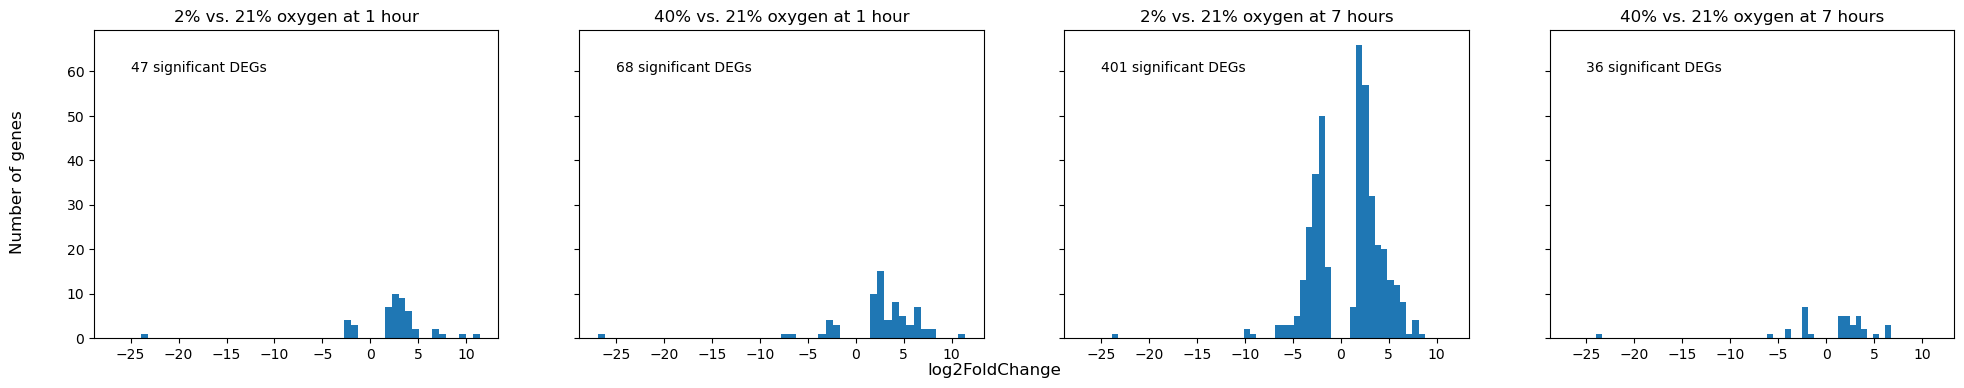

In [12]:
fig, axs = plt.subplots(1, len(o2_comparisons), sharex=True, sharey=True, figsize=(len(o2_comparisons)*6, 4))

for ax, comp in zip(axs, o2_comparisons):
    ax.hist(o2_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(conditions_semantic[comp])
    ax.text(-25, 60, f'{len(o2_comparisons[comp])} significant DEGs')
fig.supylabel('Number of genes', x=0.09)
fig.supxlabel('log2FoldChange')

Now this is interesting; we have much more skewed distributions for these comparisons, and there are many fewer genes being differentially expressed in these comparisons. Interestingly, note that there are substantially more DEGs at 7 hours in the 2% samples; this is the condition that showed a return to ambient levels of phi2. As before, we're interested in genes that have opposite behaviors between 2% and 40%; abut I am also now curious about the large number of DEGs in 2% at 7 hours.

For the time comparisons, we made the assumption that DEGs at 21% oxygen that appeared in the 2% or 40% treatments could be removed because we're interested in the differences from the ambient condition. Similarly here, we could make the assumption that the 1 hour time point is more or less the same as ambient and remove those genes from the 7 hour timepoints. However, given that the oxygen groupings separated on the PCA at 1 hour, I am not sure this is a valid assumption. To put that assumption to the test, let's see how many DEGs are in common between the oxygen comparisons at 1 hour, regardless of their directionality. If the 1 hour timepoint isn't meaningful biologically, then I would expect that most of the DEGs are in common between the two conditions.

In [13]:
shared = set(o2_comparisons['1h_o2_2_21'].gene_id).intersection(o2_comparisons['1h_o2_40_21'].gene_id)
print(f'There are {len(shared)} genes in common  between the oxygen conditions at 1 hour. This represents {(len(shared)/len(o2_comparisons["1h_o2_2_21"]))*100:.2f}% '
     f'of the total DEGs for 2% oxygen at 1 hour, and {(len(shared)/len(o2_comparisons["1h_o2_40_21"]))*100:.2f}%  of the total DEGs for 40% oxygen at 1 hour.')

There are 15 genes in common  between the oxygen conditions at 1 hour. This represents 31.91% of the total DEGs for 2% oxygen at 1 hour, and 22.06%  of the total DEGs for 40% oxygen at 1 hour.


Ok so a reasonable proportion of them are in common (at least from the perspective of presence/absence), but it's less than 1/3rd for both conditions. I am therefore going to treat the 1 hour condition as having biologically meaningful expression differences as induced by the changes in oxygen. We'll therefore look at the genes that have opposite behaviors between the oxygen conditions for both timepoints separately, and then we can dig in and see if any of those DEGs are the same for the two timepoints in a given condition (the thought being that maybe something that starts having differential expression at 1 hour has stronger differential expression at 7 hours).

In [14]:
hour1 = pd.merge(o2_comparisons['1h_o2_2_21'], o2_comparisons['1h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour1 = hour1[hour1['log2FoldChange_2o2']*hour1['log2FoldChange_40o2'] < 0]

In [15]:
hour7 = pd.merge(o2_comparisons['7h_o2_2_21'], o2_comparisons['7h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour7 = hour7[hour7['log2FoldChange_2o2']*hour7['log2FoldChange_40o2'] < 0]

In [16]:
print(f'There are {len(opposites_hour1)} opposite-behavior DEGs at 1 hour, and {len(opposites_hour7)} at 7 hours.')

There are 0 opposite-behavior DEGs at 1 hour, and 5 at 7 hours.


That is way fewer than I expected! Firstly, this means that the genes in common between the two conditions at hour 1 are both regulated in the same direction. This actually supports the idea that there is not much biologically meaningful going on at 1 hour that's caused by the changes in oxygen; however, this analysis doesn't account for the greater portion of genes that the two conditions don't have in common.

## Visualization of set overlaps
We can use UpSet plots to visualize our results better across all sets. We'll make two separate plots for the time and the oxygen comparisons for visual simplicity.

In [25]:
genes_in_time_comps = {}
for comp, df in time_comparisons.items():
    genes_in_time_comps[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

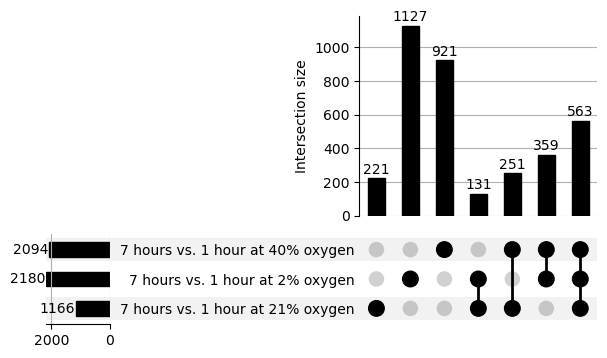

In [26]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_time_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

We also want to look at the filtered time comparisons, which means we should remove 21%, as that's what we used to remove genes that were potentially involved in circadian responses:

In [27]:
comps_filtered = {
    '7 vs. 1 h at 2% oxygen, filtered': two_filtered_by_21,
    '7 vs. 1 h at 40% oxygen, filtered': forty_filtered_by_21
}

genes_in_time_comps_filtered = {}
for comp, df in comps_filtered.items():
    genes_in_time_comps_filtered[comp] = list(set(df.gene_id.tolist()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

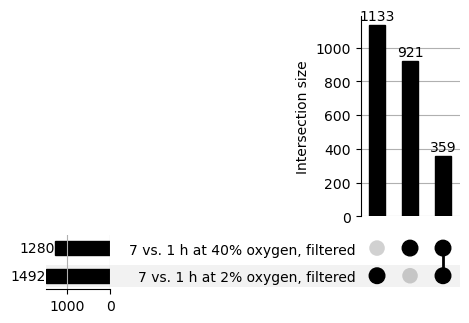

In [28]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_time_comps_filtered)
plot(to_plot, show_counts=True, sort_categories_by='input')

There are 359 genes that remain in common between the two treatments once they're filtered for circadian expression. If we look in just that set for oppositely expressed genes, what do we see?

In [17]:
genes_in_o2_comps = {}
for comp, df in o2_comparisons.items():
    genes_in_o2_comps[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

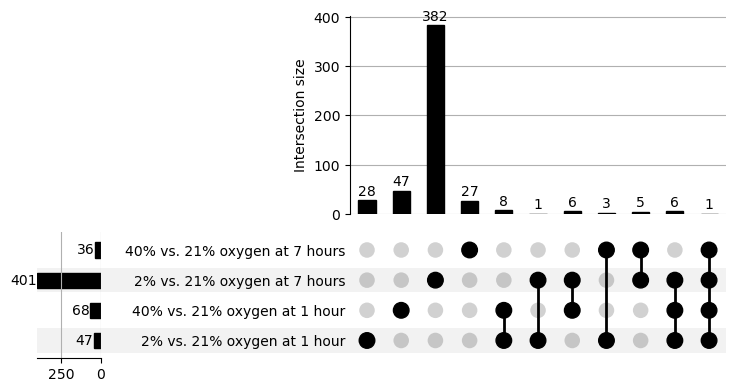

In [18]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_o2_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

What are the expression patterns of the 19 genes from 2%/7h in each of the conditions?

In [19]:
expressions_o2 = {}
for comp, genes in genes_in_o2_comps.items():
    df = o2_comparisons[reverse_condition_semantic[comp]]
    expressions_o2[comp] = df.loc[df['gene_id'].isin(genes_in_o2_comps['2% vs. 21% oxygen at 7 hours']), ['gene_id', 'log2FoldChange']]

In [20]:
# Get just the union of the ones in the other conditions and use that for 2%/7h
nineteen_shared = []
for comp, gene_df in expressions_o2.items():
    if comp != '2% vs. 21% oxygen at 7 hours':
        nineteen_shared.extend(gene_df.gene_id.tolist())
nineteen_shared = list(set(nineteen_shared))
print(len(nineteen_shared))

expressions_o2['2% vs. 21% oxygen at 7 hours'] = expressions_o2['2% vs. 21% oxygen at 7 hours'][expressions_o2['2% vs. 21% oxygen at 7 hours']['gene_id'].isin(nineteen_shared)]

19


In [31]:
# Order the 19 shared by their expression in the 2%/7h condition
nineteen_shared = expressions_o2['2% vs. 21% oxygen at 7 hours'].gene_id.tolist()

In [34]:
exp_colors = {
    '2% vs. 21% oxygen at 1 hour': 'bisque',
    '40% vs. 21% oxygen at 1 hour': 'lightsteelblue',
    '2% vs. 21% oxygen at 7 hours': 'darkorange',
    '40% vs. 21% oxygen at 7 hours': 'cornflowerblue'
}

In [38]:
expressions_o2 = {
    k: expressions_o2[k] for k in ['2% vs. 21% oxygen at 1 hour', '2% vs. 21% oxygen at 7 hours', '40% vs. 21% oxygen at 1 hour', '40% vs. 21% oxygen at 7 hours']
}

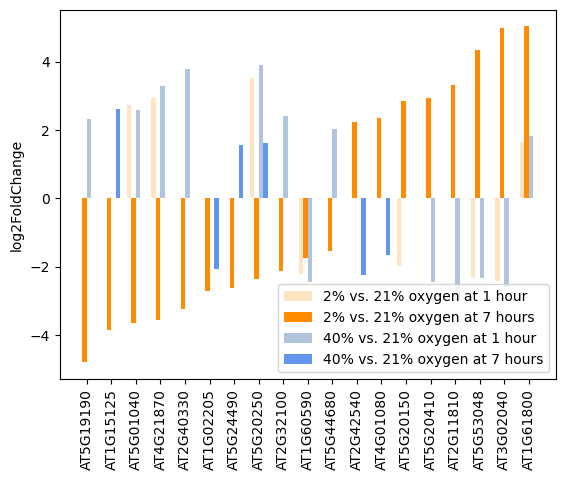

In [39]:
bar_width = 0.35
index = np.arange(len(nineteen_shared)) * (len(expressions_o2) * bar_width + 0.5) # Last two elements are bar width and space between groups

for i, group in enumerate(expressions_o2):
    gene_df = expressions_o2[group]
    gene_data = [gene_df.loc[gene_df['gene_id'] == g, 'log2FoldChange'].values[0] if len(gene_df.loc[gene_df['gene_id'] == g, 'log2FoldChange']) > 0 else np.nan for g in nineteen_shared]
    plt.bar(index + i * bar_width, gene_data, bar_width, label=group, color=exp_colors[group])

plt.xticks(index + (len(expressions_o2) * bar_width / 2) - (bar_width / 2), nineteen_shared, rotation=90)
plt.ylabel('log2FoldChange')
plt.legend()

## Time and Oxygen
There are also substantially fewer genes with opposite behavior at the 7 hour time point. Are any of these in common with our opposite behavior genes from the time comparison?

In [46]:
all_opposite = set(opposites_hour.gene_id).intersection(set(opposites_hour7.gene_id))
all_opposite

{'AT5G24490'}

Only one is in common; what is this gene? According to the [GO annotations in TAIR for this gene](https://www.arabidopsis.org/locus?name=AT5G24490#), the gene is involved in negative regulation of translational elongation and its gene product is located in the chloroplast. Is this potentially indicative of the fact that it's at the protein translational level where most of the important changes are taking place in response to oxygen? What directions does it go in the various conditions?

In [47]:
gene_of_interest = list(all_opposite)[0]
gene_of_interest_behaviors = {}
all_comparisons = dict(time_comparisons)
all_comparisons.update(o2_comparisons)
for comp, df in all_comparisons.items():
    try:
        gene_of_interest_behaviors[comp] = list(df[df['gene_id'] == gene_of_interest]['log2FoldChange'])[0]
    except IndexError:
        continue # Skips conditions where the gene doesn't appear

In [48]:
# Give some easier to parse labels for the plot
parsable_condition_names = {
    '1h_vs_7h_2o2': '1h vs. 7h\n2% oxygen',
    '1h_vs_7h_40o2': '1h vs. 7h\n40% oxygen',
    '7h_o2_2_21': '2% vs. 21%\n1 hour',
    '7h_o2_40_21': '40% vs. 21%\n1 hour'
}

Text(0.5, 1.0, 'Expression behavior of gene AT5G24490 across conditions where it appears')

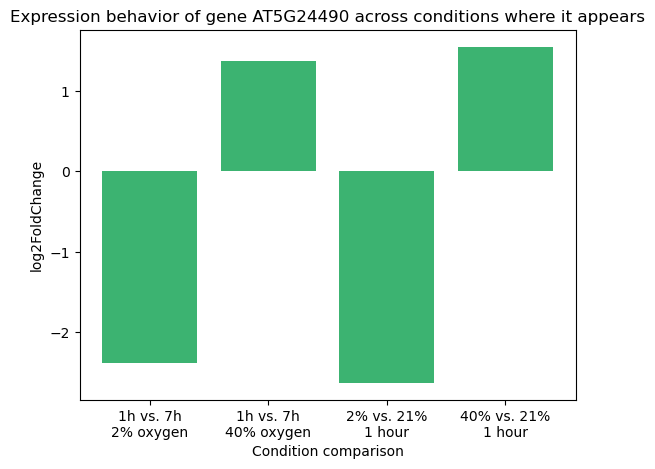

In [49]:
fig, ax = plt.subplots()

ax.bar([parsable_condition_names[k] for k in gene_of_interest_behaviors.keys()], gene_of_interest_behaviors.values(), color='mediumseagreen')
ax.set_xlabel('Condition comparison')
ax.set_ylabel('log2FoldChange')
ax.set_title(f'Expression behavior of gene {gene_of_interest} across conditions where it appears')

## Normalized expression changes over time
Something I'm interested in looking at is what the overall expression patterns look like between 7h and 1h for the three conditions. We'll do a plot in the style of WCGNA module normalized expression, but just for each condition. To do this, we need TPM values.

In [75]:
tx2gene = pd.read_csv('../data/AtRTD3_gene_transcript.csv').set_index('TXNAME').to_dict()['GENEID']
samps_path = '../data/kallisto_quant_bs'
all_tpms = {}
for samp in listdir(samps_path):
    abundances = pd.read_csv(f'{samps_path}/{samp}/abundance.tsv', sep='\t')[['target_id', 'tpm']].set_index('target_id').to_dict()['tpm']
    abundances = pd.Series({tx2gene[k]: v for k, v in abundances.items()}, name='TPM').reset_index().rename(columns={'index': 'gene_id'})
    abundances['normalized_TPM'] = (abundances['TPM'] - abundances['TPM'].min()) / (abundances['TPM'].max() - abundances['TPM'].min())
    all_tpms[samp] = abundances[['gene_id', 'normalized_TPM']]

Make a samples dataframe to help grouping what we need:

In [29]:
samples = pd.DataFrame(listdir('../data/kallisto_quant_bs/'), columns=['Sample_id'])
samples['Oxygen'] = samples.Sample_id.str.split('_').str[1].str.split('o').str[0]
samples['Time'] = samples.Sample_id.str.split('_').str[0]
samples.head()

,Sample_id,Oxygen,Time
0,7h_21o2_c,21,7h
1,1h_40o2_b,40,1h
2,1h_40o2_d,40,1h
3,7h_2o2_b,2,7h
4,7h_2o2_a,2,7h


In [34]:
sample_groups = samples.groupby(by=['Oxygen', 'Time']).agg(list)
sample_groups

Sample_id
Oxygen Time                                              
2      1h        [1h_2o2_c, 1h_2o2_e, 1h_2o2_d, 1h_2o2_b]
       7h        [7h_2o2_b, 7h_2o2_a, 7h_2o2_d, 7h_2o2_c]
21     1h    [1h_21o2_a, 1h_21o2_d, 1h_21o2_c, 1h_21o2_b]
       7h    [7h_21o2_c, 7h_21o2_a, 7h_21o2_b, 7h_21o2_d]
40     1h    [1h_40o2_b, 1h_40o2_d, 1h_40o2_a, 1h_40o2_c]
       7h    [7h_40o2_a, 7h_40o2_d, 7h_40o2_c, 7h_40o2_b]

In [76]:
tpms_by_hour = defaultdict(dict)
for sample_group in sample_groups.index:
    to_average = sample_groups.loc[sample_group].values[0]
    averaged_tpm = pd.concat([all_tpms[c] for c in to_average]).groupby('gene_id', as_index=False).agg({'normalized_TPM':'mean'})
    tpms_by_hour[sample_group[0]][sample_group[1]] = averaged_tpm

In [78]:
tpms_to_plot = {}
for o2 in ['2', '21', '40']:
    merged = pd.merge(
        tpms_by_hour[o2]['1h'],
        tpms_by_hour[o2]['7h'],
        left_on='gene_id',
        right_on='gene_id',
        suffixes=('_1h', '_7h')
    ).set_index('gene_id')
    tpms_to_plot[o2] = merged

Text(0.5, 0.01, 'Time (hours)')

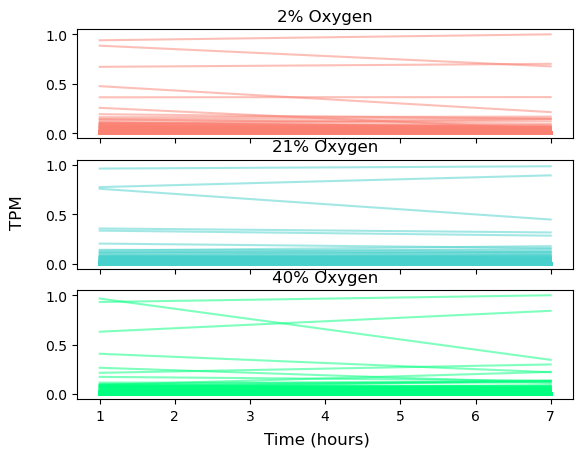

In [79]:
fig, axs = plt.subplots(len(tpms_to_plot), sharex=True, sharey=True)
colors = {'2': 'salmon', '21': 'mediumturquoise', '40': 'springgreen'}

for o2, ax in zip(tpms_to_plot.keys(), axs.flat):

    for gene in tpms_to_plot[o2].index:
        ax.plot([1, 7], tpms_to_plot[o2].loc[gene], color=colors[o2], alpha=0.5)

    ax.set_title(f'{o2}% Oxygen')

fig.supylabel('TPM')
fig.supxlabel('Time (hours)')

## Presence of photosynthetic machinery

A standing hypothesis made by physiologists about apparatuses like photosynthesis is that we wouldn't necessarily expect to see changes at the omics level in response to an environmental stimulus, because the cost of not responding fast enough is high enough that the plant would have all the machinery onboard already. We can test this hypothesis by looking for the presence of photosynthetically-related machinery in our differentially expressed genes. We'll import gene ID's to seach for from a few sources:

* The GreenCut gene list
* A list of genes involved in carbohydrate metabolism
* Photorespiration genes

While there does not exist a comprehensive list of the genes involved in the light reactions, I was able to find a resource in the supplemental data of [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC9822700/#_ad93), of light reaction-related genes that are differentially expressed under certain conditions. Looking through the genes included, it appears as if the genes that code for subunits of the major players in photosynthesis are included.

In [88]:
with open('../data/photosynthesis_genes/carb_metabolism_genes.txt') as f:
    carb_met = [l.strip().lower() for l in f.readlines()]
carb_met[:5]

['at4g24620', 'at5g51820', 'at5g19220', 'at1g27680', 'at4g39210']

In [89]:
with open('../data/photosynthesis_genes/photorespiration_genes.txt') as f:
    photorespiration = [l.strip().lower() for l in f.readlines()]
photorespiration[:5]

['at5g36700', 'at3g14420', 'at4g35090', 'at1g23310', 'at1g70580']

In [90]:
with open('../data/photosynthesis_genes/plastidCut2_genes.txt') as f:
    plastid_cut = [l.strip().lower() for l in f.readlines()]
plastid_cut[:5]

['at1g06690', 'at4g32770', 'at2g41040', 'at5g57030', 'at3g59890']

In [91]:
light_rxn_dfs = pd.read_excel('../data/photosynthesis_genes/PLD3-7-e475-s003.xlsx', sheet_name=None, header=2)
light_rxn_dfs.keys()

dict_keys(['ATP_synthase_DEG_DEseq2', 'Calvin Cycle', 'Cyclic_Electron_Flow_switch', 'Cytochrome_B6f_complex', 'LHCI proteins', 'LHCII proteins', 'NDA complex', 'Other_components_Electron_Flow', 'PSI Core proteins ', 'PSII core proteins', 'Regulatory Protein'])

In [92]:
light_rxn_dfs['ATP_synthase_DEG_DEseq2'].columns = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].iloc[1]
light_rxn_dfs['ATP_synthase_DEG_DEseq2'] = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].drop([0,1])
light_rxn_dfs['ATP_synthase_DEG_DEseq2']

1,gene,Sinusoidal Log2 Fold change,p.adjusted_S,Fluctuation Log2 Fold change,p.adjusted_F,AVG_TPM_C,AVG_TPM_S,AVG_TPM_F,Gene.name,Gene.Brief.Description
2,AT1G15700,-0.027932,0.87935,-0.35866,0.013251,4.76198,5.042359,4.069887,atpC2,"ATPase, F1 complex, gamma subunit protein"
3,AT4G32260,-0.148713,0.214356,-0.120932,0.325655,1631.566665,1577.776042,1618.384295,PDE334,"ATPase, F0 complex, subunit B/B', bacterial/ch..."
4,AT4G04640,-0.263944,0.000198,-0.080148,0.322218,1320.435898,1178.609476,1353.29015,atpC1,"ATPase, F1 complex, gamma subunit protein"
5,AT4G09650,-0.362608,0.001301,-0.214111,0.073365,1845.820232,1538.966136,1716.254467,atpD,F-type H -transporting ATPase subunit delta


In [93]:
all_light_rxns = [df['gene'].tolist() for df in light_rxn_dfs.values()]
all_light_rxns = [g.lower() for lst in all_light_rxns for g in lst]

In [94]:
lipids = pd.read_csv('../data/photosynthesis_genes/lipid_genes_holzl_and_dormann_2019.csv')
lipids.head()

,Gene,Enzymatic function,Protein,Localization,Mutanta,Mutant growth phenotypea,Reference(s)
0,At2g38040,?-Carboxyltransferase,"?-CT, CAC3",Stroma,NaN,NaN,132
1,AtCg00500 (plastome),?-Carboxyltransferase,"?-CT, accD",Stroma,NaN,NaN,126
2,At5g35360,Biotin carboxylase,"BC, CAC2",Stroma,NaN,NaN,134
3,At5g15530,Biotin carboxyl carrier protein,BCCP2,Stroma,cac1b,NaN,"26, 90"
4,At5g16390,Biotin carboxyl carrier protein,BCCP1,Stroma,cac1a,Embryolethal,"26, 90"


In [95]:
all_lipids = lipids.Gene.str.split(' ').str[0].str.lower().tolist()

Define the semantic versions of all names to be used when making plots:

In [129]:
legend_semantic = {
    'plastidCut2': 'PlastidCut 2',
    'carb_met': 'Carbohydrate metabolism',
    'lipids': 'Lipid metabolism',
    'light_rxns': 'Light reactions',
    'photorespiration': 'Photorespiration'
}

Check for overlaps between the groups:

In [97]:
genes_to_search = {
    'carb_met': list(set(carb_met)),
    'photorespiration': list(set(photorespiration)),
    'plastidCut2': list(set(plastid_cut)),
    'light_rxns': list(set(all_light_rxns)),
    'lipids': list(set(all_lipids))
}

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

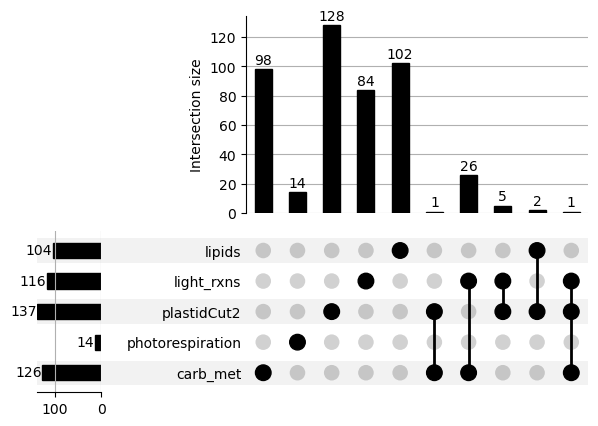

In [98]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

We want to assign genes to one of these groups uniquely; we'll do this by putting it in the most specific category. The order of specificity for these groups, from least to most:
* PlastidCut
* Carbohydrate Metabolism
* Lipids
* Light reactions
* Photorespiration

In [133]:
specificity = ['plastidCut2', 'carb_met', 'lipids', 'light_rxns', 'photorespiration']
unique_genes_to_search = {}
for i, cat in enumerate(specificity[:-1]):
    current_cat = set(genes_to_search[cat])
    for subcat in specificity[i+1:]:
        prev_len = len(current_cat)
        current_cat -= set(genes_to_search[subcat])
        print(f'Removed {prev_len - len(current_cat)} genes from {cat} using {subcat}')
    unique_genes_to_search[cat] = list(current_cat)
unique_genes_to_search['photorespiration'] = genes_to_search['photorespiration'] 

Removed 2 genes from plastidCut2 using carb_met
Removed 2 genes from plastidCut2 using lipids
Removed 5 genes from plastidCut2 using light_rxns
Removed 0 genes from plastidCut2 using photorespiration
Removed 0 genes from carb_met using lipids
Removed 27 genes from carb_met using light_rxns
Removed 0 genes from carb_met using photorespiration
Removed 0 genes from lipids using light_rxns
Removed 0 genes from lipids using photorespiration
Removed 0 genes from light_rxns using photorespiration


Check that it worked:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

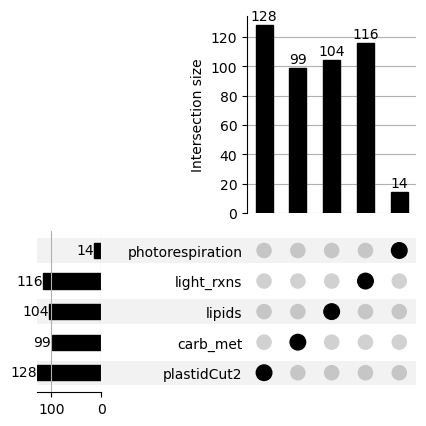

In [134]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(unique_genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

Save as a json for easier use in proteomics notebook:

In [45]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json', 'w') as f:
    json.dump(unique_genes_to_search, f)

Now check whether genes from these conditions are present in the comparisons. We'll once again do this separtely for the time and oxygen comparisons to keep the plots readable.

In [135]:
unique_genes_to_search = {legend_semantic[k]: v for k, v in unique_genes_to_search.items()}

In [136]:
unique_genes_to_search.keys()

dict_keys(['PlastidCut 2', 'Carbohydrate metabolism', 'Lipid metabolism', 'Light reactions', 'Photorespiration'])

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

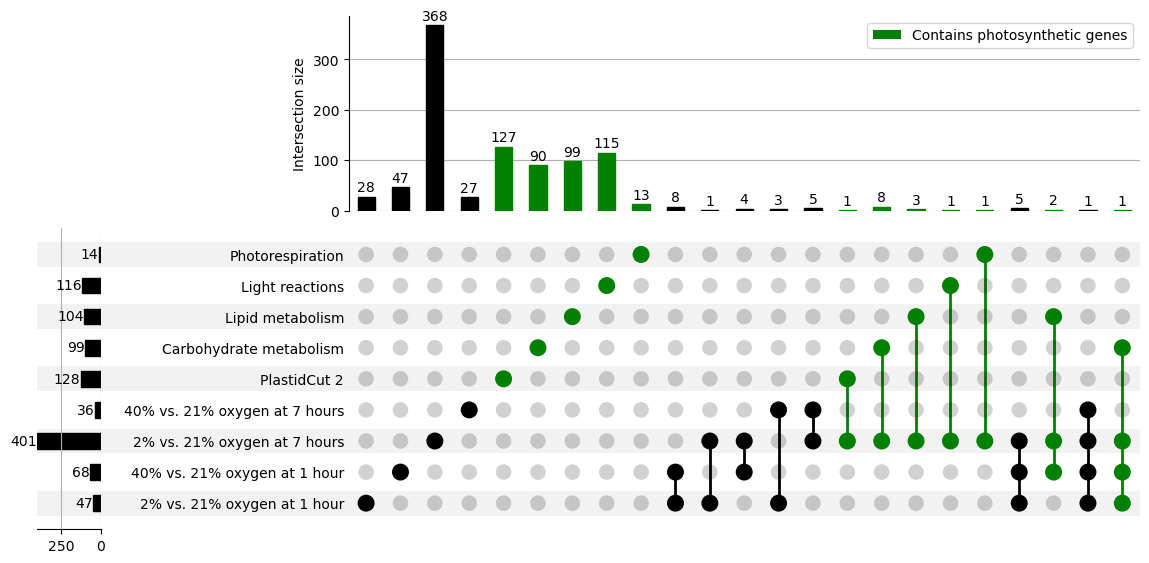

In [137]:
gene_groups_o2 = {k: [i.lower() for i in v] for k, v in genes_in_o2_comps.items()}
gene_groups_o2.update(unique_genes_to_search)
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups_o2)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
# upset.style_categories(list(unique_genes_to_search.keys()), shading_edgecolor="darkgreen", shading_linewidth=1)
for c in unique_genes_to_search.keys():
    upset.style_subsets(present=c, facecolor="green", label="Contains photosynthetic genes")
upset.plot()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

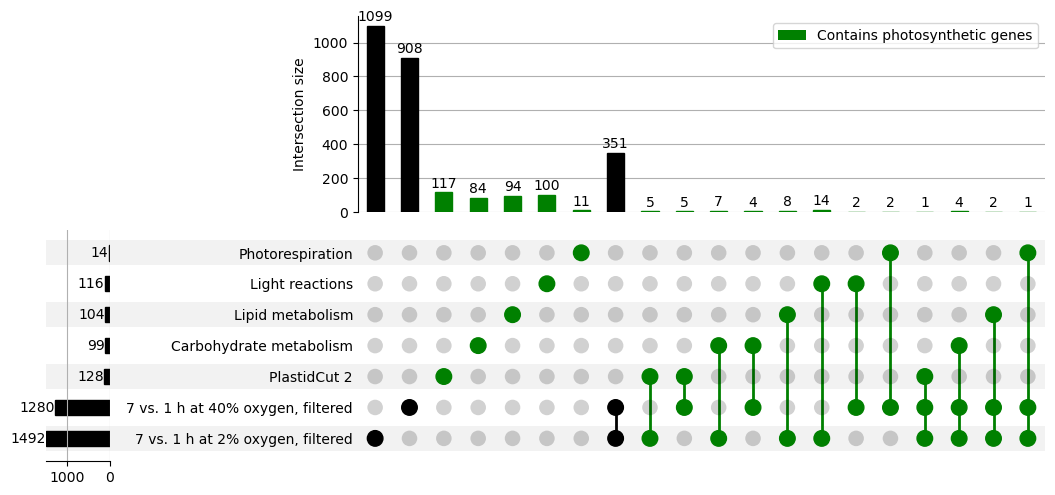

In [138]:
gene_groups_time = {k: [i.lower() for i in v] for k, v in genes_in_time_comps_filtered.items()}
gene_groups_time.update(unique_genes_to_search)
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups_time)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
# upset.style_categories(list(unique_genes_to_search.keys()), shading_edgecolor="darkgreen", shading_linewidth=1)
for c in unique_genes_to_search.keys():
    upset.style_subsets(present=c, facecolor="green", label="Contains photosynthetic genes")
upset.plot()

There is a relatively minimal amount of overlap between the photosynthesis genes and those genes that are differentially expressed. For those genes that are present, what are the expression behaviors in the dataset?

We are interested in three pieces of information with this visualization:
* What DEG sets it’s in
* What the expression changes in each DEG set looks like
* Which photosynthesis gene group it came from

We're going to do this by stacking one subfigure per DEG set, put all genes that appear anywhere in the x-axis of all of them, and color the bars by the pathway in which they appear.

In [38]:
ara = pd.read_csv('../data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k.lower(): v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}

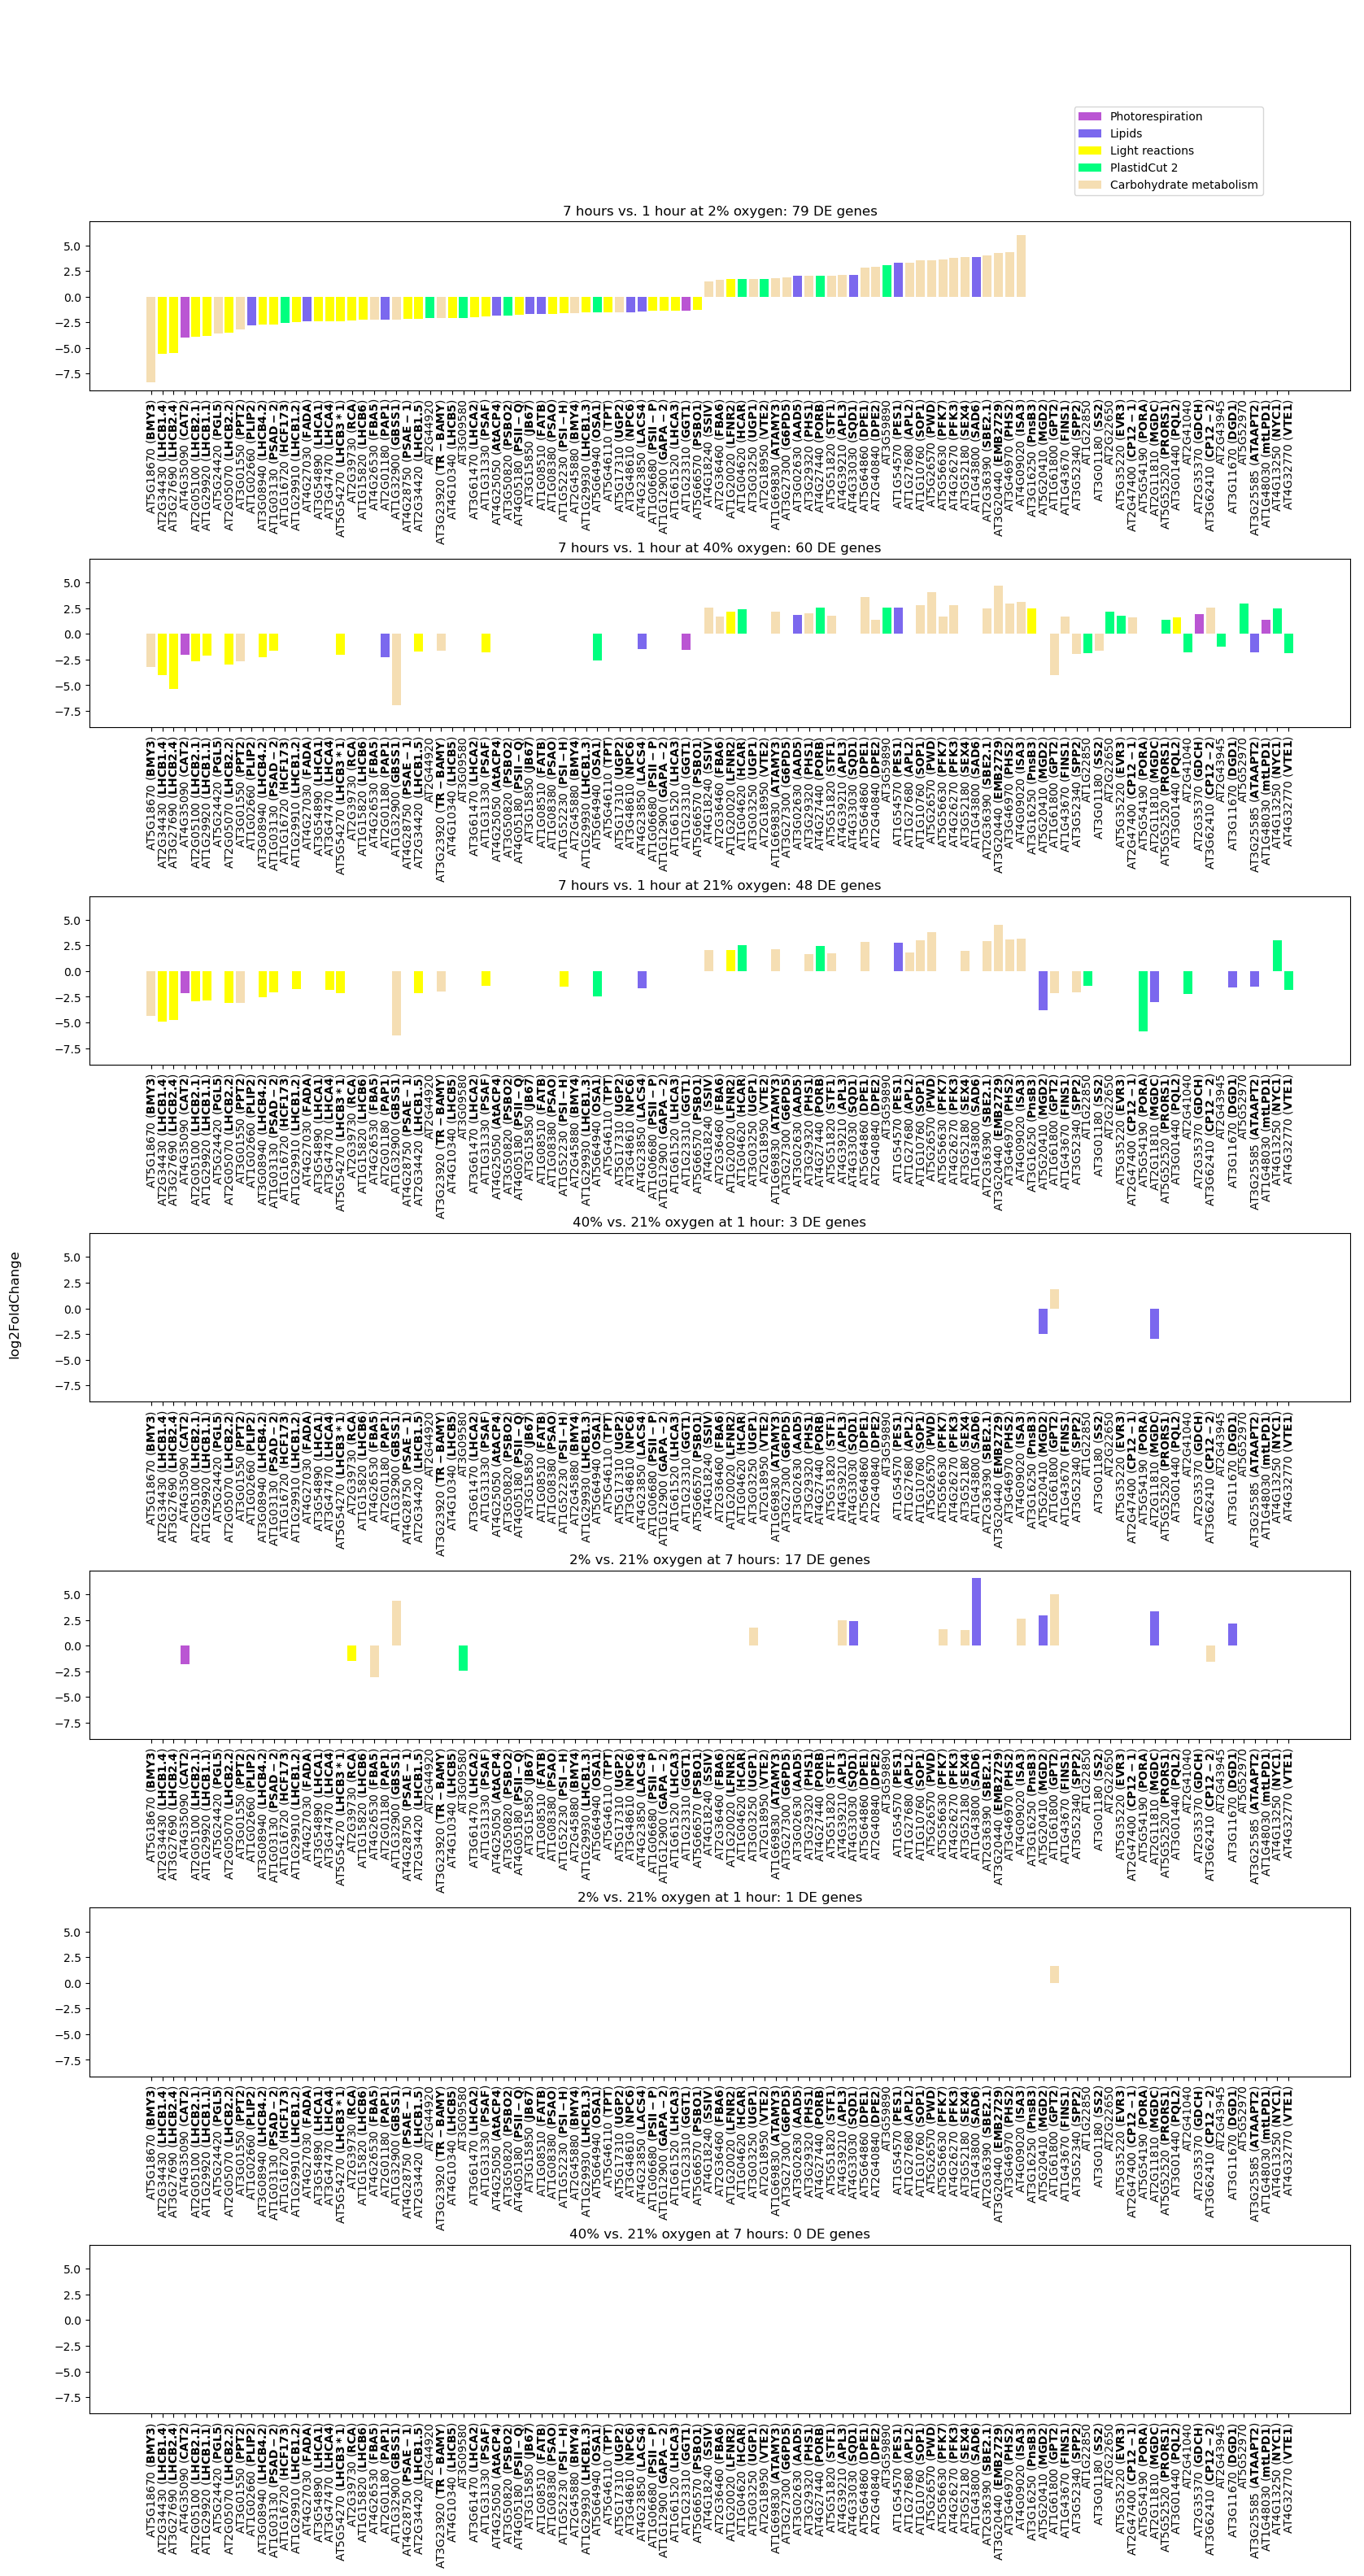

In [39]:
photosynth_colors = {'plastidCut2': 'springgreen', 'carb_met': 'wheat', 'lipids': 'mediumslateblue', 'light_rxns': 'yellow', 'photorespiration': 'mediumorchid'}
makeDEGfigure(all_comparisons, unique_genes_to_search, photosynth_colors, semantic_names, tair2gene, legend_semantic)